<a href="https://colab.research.google.com/github/oraziotorre/TTinsight/blob/main/TTinsight_ModelDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTinsight


---


## Model Development
In questo notebook vedremo tutto il processo di allenamento e testing del modello Logistic Regression e del modello LSTM

## **Inizializzazione**

In [2]:
# Gestione dei dati
import pandas as pd
import numpy as np
import os
import joblib
import ast
from collections import defaultdict
import math
import glob
import shutil
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning e metriche
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,brier_score_loss, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Deep Learning con Keras e TensorFlow
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, concatenate
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

In [3]:
# Importiamo il dataset ottenuto tramite le operazioni di Data Preprocessing
dataset = pd.read_csv("cleaned_dataset.csv")

dataset

,final_set_a,final_set_b,points_progression,score_a,score_b,comeback,half_diff,third_diff,length,set_result
0,0,0,"[0, 0, 1, 1, 0, 1, 1]",4,3,0.500000,2,2,7,0
1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0]",4,4,-0.250000,0,1,8,0
2,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0]",4,5,-0.400000,-1,-2,9,0
3,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1]",5,5,0.200000,1,-1,10,0
4,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]",6,5,0.333333,2,0,11,0
...,...,...,...,...,...,...,...,...,...,...
489295,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0]",3,6,-0.833333,-5,-2,9,0
489296,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]",4,7,0.250000,-4,-2,11,0
489297,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]",5,7,0.400000,-2,1,12,0
489298,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]",5,8,-0.125000,-3,0,13,0


## **Train-Test split**

Per ridurre il rischio di data leakage, abbiamo progettato un processo di training-test split che include diversi accorgimenti mirati:

- **Distribuzione delle tipologie di punteggi**: Assicuriamo che le stesse percentuali di tipologie di punteggi presenti nel dataset originale siano mantenute sia nel training set che nel test set. Ad esempio, se nel dataset originale il 10% delle istanze ha punteggi 4-3, garantiamo che anche nel training e nel test split sia presente il 10% di istanze con punteggi 4-3.
In questo modo la divisione dei dati di training e test sarà rappresentativa del dataset complessivo

- **Data augmentation con istanze inverse**: Appliciamo una tecnica di data augmentation che considera l’istanza inversa di ciascun punteggio. Se nel dataset originale è presente un’istanza con il punteggio 4-3, creiamo anche l’istanza inversa 3-4 con etichetta opposta. Questo processo di augmentazione avviene in fase di split, così da includere l’istanza originale e la sua controparte inversa nello stesso split, prevenendo sovrapposizioni tra training e test set e quindi situazioni di data leakage.

- **Generazione di dataset aggiuntivi**: Per le fasi successive di testing e confronto dei modelli, creiamo nuove tipologie di dataset, come quelli contenenti tutte le istanze con una differenza di punteggio pari a x, o tutte le istanze con un determinato punteggio x-y.

Questi accorgimenti ci permettono di ridurre al minimo il rischio di data leakage e migliorare la validità delle performance del modello.


In [4]:
def extract_scores(player_points):
    if isinstance(player_points, str):
        player_points = ast.literal_eval(player_points)

    count_ones = player_points.count(1)
    count_zeros = player_points.count(0)

    return f"{count_ones}-{count_zeros}"

# Funzione che calcola e ritorna le combinazioni di punteggio
def count_score_combinations(dataframe):
    score_combinations = dataframe['points_progression'].apply(extract_scores)
    return score_combinations.value_counts()

# Calcolo e stampa delle combinazioni
score_count = count_score_combinations(dataset)
print(score_count)

points_progression
4-3    18156
3-4    17960
4-4    17646
4-5    16032
5-4    15932
5-5    15734
5-3    14858
3-5    14741
6-5    14481
5-6    14262
6-6    14256
6-4    13625
4-6    13457
7-6    13280
6-7    13102
7-7    13051
7-5    12586
5-7    12381
8-7    12170
7-8    12062
8-6    11810
8-8    11792
5-2    11702
2-5    11541
6-3    11500
6-8    11496
3-6    11282
9-8    11251
7-4    11143
8-9    11093
9-7    11038
4-7    11022
9-9    10952
7-9    10867
8-5    10599
5-8    10406
9-6    10088
6-9     9946
Name: count, dtype: int64


Suddivisione del dataset originale in set distinti per ciascuna tipologia di punteggio. In altre parole, creiamo dataset separati per ogni combinazione di punteggio, come ad esempio per i punteggi 4-3, 4-4, 5-5, e così via.

In [5]:
# Funzione per calcolare la combinazione di punteggi
def extract_scores(points_progression):

    if isinstance(points_progression, str):
        points_progression = ast.literal_eval(points_progression)

    count_ones = points_progression.count(1)
    count_zeros = points_progression.count(0)

    return f"{count_ones}-{count_zeros}"

# Funzione per creare i dataset separati in base alla combinazione di punteggi
def create_datasets_by_score_combinations(df):
    score_combinations = df['points_progression'].apply(extract_scores)
    datasets = defaultdict(list)
    for index, row in df.iterrows():
        score_combination = score_combinations[index]
        datasets[score_combination].append(row)

    result_datasets = {}
    for score_combination, rows in datasets.items():
        result_datasets[score_combination] = pd.DataFrame(rows)

    return result_datasets


# Funzione per salvare i dataset in una cartella
def save_datasets_to_folder(datasets, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for score_combination, dataset in datasets.items():
        num_rows = len(dataset)
        filename = f"{score_combination}.csv"
        filepath = os.path.join(folder_path, filename)
        dataset.to_csv(filepath, index=False)


# Esegui la funzione sul dataset
result_datasets = create_datasets_by_score_combinations(dataset)

# Specifica la cartella dove salvare i file
folder_path = '/content/datasets'

# Salva i dataset separati nella cartella
save_datasets_to_folder(result_datasets, folder_path)

Per ogni nuovo dataset relativo a una specifica tipologia di punteggio, eseguiamo una suddivisione in un training set e un test set con una proporzione dell'80/20. In questo modo, ad esempio, il dataset delle istanze con punteggio 4-3 verrà separato in due nuovi file: 4-3_train per il training set e 4-3_test per il test set. Questo processo viene ripetuto per ogni tipologia di punteggio, creando un file di training e uno di test per ciascun gruppo.

In [6]:
# Funzione per fare il train-test split sui file CSV
def split_train_test_for_csv_files(input_folder, output_folder, test_size=0.2, random_state=42):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_folder, file_name)

            df = pd.read_csv(file_path)

            # Suddividi il dataset in training e test (80/20)
            train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)

            train_filename = file_name.replace(".csv", "_train.csv")
            test_filename = file_name.replace(".csv", "_test.csv")

            train_filepath = os.path.join(output_folder, train_filename)
            test_filepath = os.path.join(output_folder, test_filename)

            train_data.to_csv(train_filepath, index=False)
            test_data.to_csv(test_filepath, index=False)



input_folder = '/content/datasets'  # Cartella dove sono i file CSV originali
output_folder = '/content/split_datasets'  # Cartella dove salvare i file divisi

split_train_test_for_csv_files(input_folder, output_folder)

Per ogni dataset di train e test, modifichiamo il file in modo da includere anche le rispettive istanze invertite. Ad esempio, per ogni istanza x del dataset di train dei punteggi di 4-3, verrà generata l'istanza inversa (cioè 3-4 con etichetta opposta) e verrà aggiunta nello stesso dataset.

In [7]:
# Funzione per creare il dataset con le istanze invertite
def create_inverso_dataset(df):
    inverso_df = df.copy()

    # Calcolo delle feature opposte (inversioni e cambiamenti dei segni)
    inverso_df['final_set_a'], inverso_df['final_set_b'] = inverso_df['final_set_b'], inverso_df['final_set_a']
    inverso_df['points_progression'] = inverso_df['points_progression'].apply(lambda points: [1 - p for p in ast.literal_eval(points)])
    inverso_df['score_a'], inverso_df['score_b'] = inverso_df['score_b'], inverso_df['score_a']
    inverso_df['comeback'] = -inverso_df['comeback']
    inverso_df['half_diff'] = -inverso_df['half_diff']
    inverso_df['third_diff'] = -inverso_df['third_diff']
    inverso_df['set_result'] = 1 - inverso_df['set_result']

    return inverso_df

# Funzione per caricare, creare e salvare i dataset "inverso"
def create_inverso_datasets(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        if file_name.endswith(("_train.csv", "_test.csv")):
            file_path = os.path.join(input_folder, file_name)
            df = pd.read_csv(file_path)

            inverso_df = create_inverso_dataset(df)

            # Creazione del nome file invertito
            base_name = file_name.split('_')[0]
            inverted_score = '-'.join(base_name.split('-')[::-1])
            inverso_filename = f"{inverted_score}_train_opp.csv" if "_train" in file_name else f"{inverted_score}_test_opp.csv"
            inverso_filepath = os.path.join(output_folder, inverso_filename)
            inverso_df.to_csv(inverso_filepath, index=False)


input_folder = '/content/split_datasets'  # Cartella con i file originali (train e test)
inverso_folder = '/content/inverso_datasets'  # Cartella con i file degli inversi (train_opp e test_opp)

create_inverso_datasets(input_folder, inverso_folder)

In [8]:
# Funzione per unire i dataset originali con quelli inversi
def merge_datasets(original_folder, opponent_folder, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella degli originali (train e test)
    original_train_files = {f.replace("_train.csv", ""): f for f in os.listdir(original_folder) if f.endswith("_train.csv")}
    opponent_train_files = {f.replace("_train_opp.csv", ""): f for f in os.listdir(opponent_folder) if f.endswith("_train_opp.csv")}

    original_test_files = {f.replace("_test.csv", ""): f for f in os.listdir(original_folder) if f.endswith("_test.csv")}
    opponent_test_files = {f.replace("_test_opp.csv", ""): f for f in os.listdir(opponent_folder) if f.endswith("_test_opp.csv")}

    # Unisci i file per il training
    for base_name, original_file in original_train_files.items():
        opponent_file = opponent_train_files.get(base_name)

        if opponent_file:
            original_path = os.path.join(original_folder, original_file)
            opponent_path = os.path.join(opponent_folder, opponent_file)

            original_df = pd.read_csv(original_path)
            opponent_df = pd.read_csv(opponent_path)

            merged_train_df = pd.concat([original_df, opponent_df], ignore_index=True)

            merged_train_filename = f"merged_{original_file}"
            merged_train_filepath = os.path.join(output_folder, merged_train_filename)
            merged_train_df.to_csv(merged_train_filepath, index=False)


    # Unisci i file per il test
    for base_name, original_file in original_test_files.items():
        opponent_file = opponent_test_files.get(base_name)

        if opponent_file:
            original_path = os.path.join(original_folder, original_file)
            opponent_path = os.path.join(opponent_folder, opponent_file)

            original_df = pd.read_csv(original_path)
            opponent_df = pd.read_csv(opponent_path)
            merged_test_df = pd.concat([original_df, opponent_df], ignore_index=True)

            merged_test_filename = f"merged_{original_file}"
            merged_test_filepath = os.path.join(output_folder, merged_test_filename)
            merged_test_df.to_csv(merged_test_filepath, index=False)


original_folder = '/content/split_datasets'  # Cartella con i file originali (train e test)
opponent_folder = '/content/inverso_datasets'  # Cartella con i file degli inversi
output_folder = '/content/merged_datasets'  # Cartella dove salvare i file uniti

merge_datasets(original_folder, opponent_folder, output_folder)

Organizza i file di test suddividendoli in base alle diverse tipologie, in modo da facilitare le sperimentazioni successive.

In [9]:
def sposta_e_rinomina_file():
    cartella_originale = "merged_datasets"
    cartella_test = "dataset_train"

    if not os.path.exists(cartella_test):
        os.makedirs(cartella_test)

    for file_name in os.listdir(cartella_originale):
        if "train" in file_name:
            nuovo_nome = file_name.replace("merged_", "")
            percorso_originale = os.path.join(cartella_originale, file_name)
            percorso_nuovo = os.path.join(cartella_test, nuovo_nome)
            shutil.move(percorso_originale, percorso_nuovo)


sposta_e_rinomina_file()

In [10]:
def sposta_e_rinomina_file():
    cartella_originale = "merged_datasets"
    cartella_test = "dataset_test"

    if not os.path.exists(cartella_test):
        os.makedirs(cartella_test)

    for file_name in os.listdir(cartella_originale):
        if "test" in file_name:
            nuovo_nome = file_name.replace("merged_", "")
            percorso_originale = os.path.join(cartella_originale, file_name)
            percorso_nuovo = os.path.join(cartella_test, nuovo_nome)
            shutil.move(percorso_originale, percorso_nuovo)


sposta_e_rinomina_file()

Genera nuovi file in base alla differenza di punteggio che ci serviranno successivamente per testare i modelli. Ad esempio, i dataset di test con punteggi 5-5, 6-6, 7-7, ecc., saranno uniti in un unico dataset corrispondente alla differenza di punteggio 0.

In [11]:
def calculate_difference(filename):
    base_name = filename.replace('_train.csv', '').replace('_test.csv', '')
    parts = base_name.split('-')

    num1 = int(parts[0])
    num2 = int(parts[1])

    return abs(num1 - num2)

def merge_and_save_datasets_by_difference(dataset_train_path, dataset_test_path, output_train_folder, output_test_folder):
    train_diff_dfs = {i: [] for i in range(4)}
    test_diff_dfs = {i: [] for i in range(4)}

    train_files = [f for f in os.listdir(dataset_train_path) if f.endswith('.csv')]
    for file in train_files:
        diff = calculate_difference(file)
        if diff <= 3:
            df = pd.read_csv(os.path.join(dataset_train_path, file))
            train_diff_dfs[diff].append(df)

    test_files = [f for f in os.listdir(dataset_test_path) if f.endswith('.csv')]
    for file in test_files:
        diff = calculate_difference(file)
        if diff <= 3:
            df = pd.read_csv(os.path.join(dataset_test_path, file))
            test_diff_dfs[diff].append(df)

    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    for diff in range(4):
        if train_diff_dfs[diff]:
            train_merged = pd.concat(train_diff_dfs[diff], ignore_index=True)
            train_merged.to_csv(os.path.join(output_train_folder, f"dataset_train_diff_{diff}.csv"), index=False)

        if test_diff_dfs[diff]:
            test_merged = pd.concat(test_diff_dfs[diff], ignore_index=True)
            test_merged.to_csv(os.path.join(output_test_folder, f"dataset_test_diff_{diff}.csv"), index=False)


dataset_train_path = '/content/merged_datasets'
dataset_test_path = '/content/dataset_test'
output_train_folder = '/content/dataset_train_diff'
output_test_folder = '/content/dataset_test_diff'

merge_and_save_datasets_by_difference(dataset_train_path, dataset_test_path, output_train_folder, output_test_folder)

Uniamo tutti i dataset di training in un unico dataset di training finale e uniamo tutti i dataset di test in un unico dataset di test finale

In [12]:
# Funzione per caricare e combinare i file
def load_and_combine_files(folder_path, file_pattern):
    file_paths = glob.glob(os.path.join(folder_path, file_pattern))
    return pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)

# Esegui la combinazione per i file di training
combined_train_data = load_and_combine_files('dataset_train', '*.csv')
combined_train_data.to_csv('training_set.csv', index=False)

# Esegui la combinazione per i file di test
combined_test_data = load_and_combine_files('dataset_test', '*.csv')
combined_test_data.to_csv('test_set.csv', index=False)

Rimuovo tutti i file generati durante il processo di split che non saranno necessari.

In [13]:
# Funzione per eliminare cartelle specificate
def delete_folders(folders):
    for folder in folders:
        if os.path.exists(folder):
            try:
                shutil.rmtree(folder)
            except Exception as e:
                print(f"Errore durante l'eliminazione della cartella '{folder}': {e}")
        else:
            print(f"La cartella '{folder}' non esiste.")

# Lista delle cartelle da eliminare
folders_to_delete = ['/content/datasets', '/content/split_datasets', '/content/inverso_datasets','/content/merged_datasets']

delete_folders(folders_to_delete)

Importazione dei set di training e test generati

In [14]:
training_set = pd.read_csv("training_set.csv")
training_set = training_set.sample(frac=1, random_state=42).reset_index(drop=True)

test_set = pd.read_csv("test_set.csv")
test_set = test_set.sample(frac=1, random_state=42).reset_index(drop=True)

dataset = pd.concat([training_set, test_set], ignore_index=True)
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)


dataset

,final_set_a,final_set_b,points_progression,score_a,score_b,comeback,half_diff,third_diff,length,set_result
0,1,0,"[1, 0, 1, 0, 1, 1, 1, 0, 1]",6,3,0.166667,3,0,9,1
1,0,0,"[1, 1, 0, 0, 0, 1, 0, 1, 1]",5,4,0.400000,1,2,9,0
2,1,0,"[1, 1, 1, 0, 0, 1, 1]",5,2,0.400000,0,2,7,1
3,0,0,"[0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, ...",8,9,-0.111111,1,2,17,1
4,1,0,"[1, 0, 1, 0, 1, 0, 1, 1, 0, 1]",6,4,0.166667,1,1,10,1
...,...,...,...,...,...,...,...,...,...,...
978595,1,0,"[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...",8,9,0.125000,-1,0,17,0
978596,0,0,"[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1]",8,7,0.125000,2,2,15,1
978597,0,1,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]",4,7,0.750000,0,2,11,0
978598,0,0,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]",5,7,0.400000,0,1,12,1


Controlliamo la distribuzione delle etichette per i dataset generati

In [15]:
training_labels = training_set['set_result'].value_counts()
test_labels = test_set['set_result'].value_counts()

# Conta le etichette nei dataset concatenati
dataset_labels = dataset['set_result'].value_counts()

# Stampa i risultati
print("Distribuzione etichette nel training set:")
print(training_labels)

print("\nDistribuzione etichette nel test set:")
print(test_labels)

print("\nDistribuzione etichette nel dataset combinato:")
print(dataset_labels)

Distribuzione etichette nel training set:
set_result
1    391420
0    391420
Name: count, dtype: int64

Distribuzione etichette nel test set:
set_result
0    97880
1    97880
Name: count, dtype: int64

Distribuzione etichette nel dataset combinato:
set_result
1    489300
0    489300
Name: count, dtype: int64


## **Logistic Regression**
Il modello di **Logistic Regression**, essendo incapace di catturare le dipendenze temporali o sequenziali, è stato allenato su un set di feature che sintetizzano le principali caratteristiche temporali della sequenza. In questo modo, siamo riusciti a rappresentare le dinamiche temporali in modo efficace, senza compromettere troppo l’efficacia del modello

In [16]:
columns = ['final_set_a', 'final_set_b', 'score_a', 'score_b', 'comeback', 'half_diff','third_diff', 'length']

X_train_log_reg = training_set[columns].values
Y_train_log_reg = training_set['set_result'].values

X_test_log_reg = test_set[columns].values
Y_test_log_reg = test_set['set_result'].values

#### Scaling

In [17]:
scaler_log_reg = StandardScaler()

X_train_log_reg = scaler_log_reg.fit_transform(X_train_log_reg)
X_test_log_reg = scaler_log_reg.transform(X_test_log_reg)

#### Training

In [18]:
# Logistic Regression
baseline_log_reg = LogisticRegression(max_iter=1000, random_state=42)

baseline_log_reg.fit(X_train_log_reg, Y_train_log_reg)

LogisticRegression(max_iter=1000, random_state=42)

#### Hyperparameter Tuning

In [ ]:
# Definisci i possibili valori degli iperparametri
param_grid = {
    'C': np.logspace(-4, 4, 9),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Crea l'oggetto GridSearchCV
grid_search = GridSearchCV(estimator=baseline_log_reg, param_grid=param_grid, cv=5,
                           scoring='neg_log_loss')  # Usa 'neg_log_loss' per Log Loss

# Esegui la ricerca
grid_search.fit(X_train_log_reg, Y_train_log_reg)

# Visualizza i migliori parametri trovati
print("Migliori parametri:", grid_search.best_params_)

# Ottieni il miglior modello
tuned_log_reg = grid_search.best_estimator_

Migliori parametri: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
joblib.dump(tuned_log_reg, 'LogReg.pkl')

['LogReg.pkl']

## **LSTM**

Dopo aver utilizzato la Logistic Regression con feature riassuntive, abbiamo deciso di utilizzare un modello in grado di catturare meglio le dipendenze temporali all'interno delle sequenze.

Gli **LSTM** sono particolarmente efficaci nel modellare sequenze complesse, poiché sono in grado di memorizzare informazioni rilevanti nel tempo e di ignorare quelle meno significative, permettendo al modello di catturare dinamiche e pattern che la regressione logistica non potrebbe rilevare.

Abbiamo deciso di addestrare il modello LSTM utilizzando le sequenze complete dei punti `points_progression` e integrando due feature globali: `finale_set_a` e `finale_set_b`. Questo approccio permette al modello di cogliere le dinamiche temporali dei punti, mantenendo al contempo informazioni globali per il contesto del set, migliorando così la capacità predittiva del modello.

In [22]:
'''
Da usare alla fine quando abbiamo finito il training e il testing e quindi vogliamo avere il modello finale

# Carica i dati dal dataset (presumibilmente già caricati come training_set)
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)
global_features = np.array(dataset[['is_final', 'final_set_a', 'final_set_b']])

# Converti ogni stringa in una lista di interi
player_points_converted = [eval(seq) if isinstance(seq, str) else seq for seq in player_points]

# Padding delle sequenze
max_sequence_length = 18  # Impostato come precedentemente
player_points_padded = pad_sequences(player_points_converted , maxlen=max_sequence_length, padding='post', truncating='post', value=-1)


X_train_seq = player_points_padded
X_train_global = global_features
Y_train = set_result
'''

# Creazione del set di testing

# Carica i dati dal dataset di test
player_points_test = np.array(test_set['points_progression'].values)
set_result_test = np.array(test_set['set_result'].values)
global_features_test = np.array(test_set[['final_set_a', 'final_set_b']])

# Padding delle sequenze di test
player_points_converted_test = [eval(seq) if isinstance(seq, str) else seq for seq in player_points_test]
player_points_padded_test = pad_sequences(player_points_converted_test, maxlen=18, padding='post', truncating='post', value=-1)

X_test_seq = player_points_padded_test
X_test_global = global_features_test
Y_test = set_result_test

In [23]:
# Creazione del set di training

# Carica i dati dal dataset
player_points = np.array(training_set['points_progression'].values)
set_result = np.array(training_set['set_result'].values)
global_features = np.array(training_set[['final_set_a','final_set_b']])


# Padding
player_points_converted = [eval(seq) if isinstance(seq, str) else seq for seq in player_points]
player_points_padded = pad_sequences(player_points_converted , maxlen=18, padding='post', truncating='post', value=-1)


X_train_seq = player_points_padded
X_train_global = global_features
Y_train = set_result

#### Training

In [ ]:
# Preparazione dei dati per l'input del modello

# Input per sequenze
sequence_input = Input(shape=(18,), name='sequence_input')

# Embedding per valori diversi dal padding
x = Embedding(input_dim=3, output_dim=32)(sequence_input)

# Primo strato LSTM con 64 unità, che restituisce l'intera sequenza.
x = LSTM(64, return_sequences=True)(x)

# Secondo strato LSTM con 32 unità, che restituisce solo l'ultimo stato.
x = LSTM(32, return_sequences=False)(x)

# Input per feature globali
global_input = Input(shape=(2,), name='global_input')
global_dense = Dense(16, activation='relu')(global_input)

# Combina i due input
combined = concatenate([x, global_dense])

# Aggiungi Dropout per ridurre l'overfitting
x = Dropout(0.3)(combined)

# Strato denso con 32 unità per la combinazione.
x = Dense(32, activation='relu')(x)

# Output del modello con attivazione sigmoide per classificazione binaria
output = Dense(1, activation='sigmoid')(x)

# Costruisci il modello
lstm_model = Model(inputs=[sequence_input, global_input], outputs=output)

# Compila il modello
lstm_model.compile(optimizer='adam', loss='binary_crossentropy')

# Allenamento del modello LSTM
history_lstm = lstm_model.fit([X_train_seq, X_train_global], Y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 317s 25ms/step - loss: 0.5782
Epoch 2/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 309s 25ms/step - loss: 0.5707
Epoch 3/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 321s 25ms/step - loss: 0.5687
Epoch 4/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 308s 25ms/step - loss: 0.5688
Epoch 5/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 341s 27ms/step - loss: 0.5678
Epoch 6/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 433s 31ms/step - loss: 0.5673
Epoch 7/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 374s 30ms/step - loss: 0.5659
Epoch 8/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 417s 33ms/step - loss: 0.5653
Epoch 9/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 383s 28ms/step - loss: 0.5644
Epoch 10/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 349s 29ms/step - loss: 0.5625
Epoch 11/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 408s 31ms/step - loss: 0.5618
Epoch 12/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 407s 33ms/step - loss: 0.5610
Epoch 13/20
12232/12232 ━━━━━━━━━━━━━━━━━━━━ 374s 31ms/step - loss: 0.5595
Epoch 14/20
12232/12232 ━━━━━━━━━━

In [ ]:
lstm_model.save('LSTM_20.keras')

#### Check Predictions

In [ ]:
'''
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],  # 5-5 combattuta
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],  # 5-5 rimonta mia
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # 5-5 rimonta sua
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # 6-5 combattuta
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # 6-5 rimonta mia
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # 6-5 rimonta sua
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 9-9 rimonta sua
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 9-9 rimonta mia
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 1],  # 4-6 combattuta
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # 4-6 rimonta sua
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],  # 4-6 rimonta mia
'''

# Esempi delle sequenze di test
test_examples = [
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # 6-5 combattuta
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # 6-5 rimonta mia
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # 6-5 rimonta sua
]

global_features_example = [[0, 0] for seq in test_examples]
X_global = np.array(global_features_example)
X_seq = pad_sequences(test_examples, maxlen=18, padding='post', truncating='post', value=-1)

# Prevedi le probabilità usando il modello LSTM
y_pred_prob_new = lstm_model.predict([X_seq, X_global])

# Stampa le previsioni per ciascun esempio
for i, example in enumerate(test_examples):
    print(f"Esempio {i+1}: {example}")
    print(f"Probabilità previste: {y_pred_prob_new[i][0]:.4f}")
    print("-" * 50)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Esempio 1: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Probabilità previste: 0.6553
--------------------------------------------------
Esempio 2: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Probabilità previste: 0.6415
--------------------------------------------------
Esempio 3: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.5278
--------------------------------------------------


Si osserva che, nel caso dell'esempio preso in considerazione, il modello interpreta le situazioni di rimonta avversaria come **negative**, una valutazione più coerente e sensata rispetto a quella fornita dal modello di Logistic Regression, che tendeva a considerarle in modo opposto.

## Analisi dei risultati **Logistic Regression** e **LSTM**

Procediamo ora con il confronto delle prestazioni tra i due modelli, **Logistic Regression** e **LSTM**, per valutare le differenze dei risultati

In [19]:
# Carica il modello
tuned_log_reg = joblib.load('LogReg.pkl')

In [20]:
lstm_model = tf.keras.models.load_model('LSTM_20-64_train.keras')

#### Testing dei modelli

In [26]:
# Funzione di valutazione del modello
def evaluate_model(model, X_test, Y_test):
    # Calcola le predizioni probabilistiche
    if model == lstm_model:
        # Per il modello LSTM, assumi che l'output sia un array di probabilità
        y_pred_prob = model.predict([X_test_seq, X_test_global])
    else:
        # Per modelli come Logistic Regression, ottieni le probabilità per la classe positiva
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilità classe positiva

    # Calcola le metriche richieste
    log_loss_score = log_loss(Y_test, y_pred_prob)
    brier_score = brier_score_loss(Y_test, y_pred_prob)

    return {
        'Log Loss': log_loss_score,
        'Brier Score': brier_score
    }

# Calcolare le metriche per il modello LSTM
lstm_results = evaluate_model(lstm_model, X_test_seq, Y_test)

# Calcolare le metriche per il modello baseline
baseline_results = evaluate_model(baseline_log_reg, X_test_log_reg, Y_test_log_reg)

# Calcolare le metriche per il modello ottimizzato
tuned_results = evaluate_model(tuned_log_reg, X_test_log_reg, Y_test_log_reg)

# Stampa dei risultati per il confronto
print("\n--- Performance Comparison ---")
print(f"LSTM Log Loss (Test): {lstm_results['Log Loss']:.6f} | Baseline Log Loss (Test): {baseline_results['Log Loss']:.6f} | Tuned Log Loss (Test): {tuned_results['Log Loss']:.6f}")
print(f"LSTM Brier Score (Test): {lstm_results['Brier Score']:.6f} | Baseline Brier Score (Test): {baseline_results['Brier Score']:.6f} | Tuned Brier Score (Test): {tuned_results['Brier Score']:.6f}")

6118/6118 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step

--- Performance Comparison ---
LSTM Log Loss (Test): 0.558956 | Baseline Log Loss (Test): 0.566879 | Tuned Log Loss (Test): 0.566878
LSTM Brier Score (Test): 0.188693 | Baseline Brier Score (Test): 0.191827 | Tuned Brier Score (Test): 0.191827


Le prestazioni tra il modello Baseline e il modello Tuned Baseline sono praticamente identiche. Questo è evidente dai risultati ottenuti, dove il Log Loss (0.566879 per il Baseline e 0.566878 per il Tuned) e il Brier Score (0.191827 per entrambi) mostrano differenze trascurabili, quasi nulle.

Il motivo di questa similitudine risiede probabilmente nel fatto che il modello Baseline di partenza era già ben progettato e ottimizzato, lasciando poco spazio a ulteriori miglioramenti tramite il tuning. Le modifiche introdotte non hanno aggiunto nuove informazioni o capacità al modello, portando quindi a prestazioni sostanzialmente equivalenti.

D'altro canto, il modello LSTM ha dimostrato prestazioni superiori rispetto sia al Baseline che al Tuned Baseline. Con un Log Loss di 0.558956 e un Brier Score di 0.188693, l'LSTM risulta migliore sia nella stima delle probabilità (Log Loss) che nella calibrazione delle previsioni (Brier Score). Questo indica che l'LSTM è stato in grado di sfruttare le sue capacità di modellare relazioni complesse nei dati, superando i modelli Baseline nonostante il miglioramento sia relativamente contenuto.

In [27]:
# Considero il modello migliore per le future analisi
log_reg = tuned_log_reg

#### Feature Importance Analysis
La mean decrease in Gini impurity (media della diminuzione dell'impurità di Gini) è una metrica utilizzata per valutare l'importanza di una caratteristica. Viene calcolata come la diminuzione media dell'impurità di Gini che una caratteristica provoca in ogni albero della foresta randomica quando viene utilizzata per dividere i dati. Più una caratteristica riduce l'impurità di Gini, più è considerata importante.
Attraverso un grafico che mostra la diminuzione media dell'impurità di Gini per ciascuna caratteristica possiamo vedere quali feature contribuiscono maggiormente al processo di classificazione.

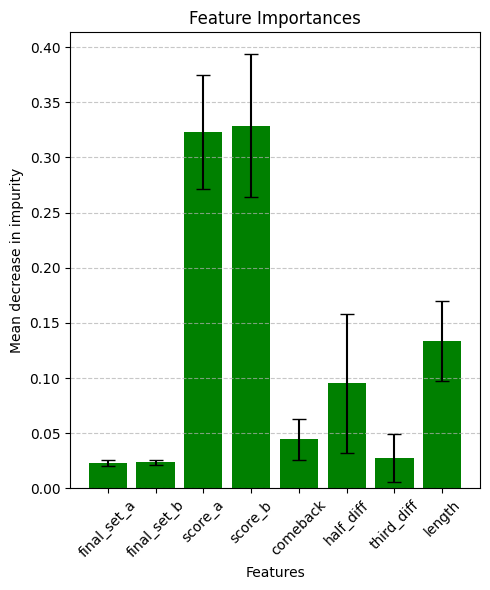

In [ ]:
X = np.array((dataset[['final_set_a', 'final_set_b', 'score_a', 'score_b','comeback','half_diff','third_diff','length']].values))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Y = np.array(dataset['set_result'].values)


# Crea e allena il modello di Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, Y)


# Variabili per raccogliere i risultati
feature_importances = []
# Nomi delle feature
feature_names = ['final_set_a', 'final_set_b', 'score_a', 'score_b','comeback','half_diff','third_diff','length']

# Estrai le feature importance per ogni albero
tree_importances = np.array([tree.feature_importances_ for tree in rf.estimators_])

# Calcola la media e la deviazione standard per ogni feature
mean_importances = tree_importances.mean(axis=0)
std_importances = tree_importances.std(axis=0)

plt.figure(figsize=(5, 6))
plt.bar(feature_names, mean_importances, yerr=std_importances, color="green", alpha=1, capsize=5)
plt.title("Feature Importances")
plt.ylabel("Mean decrease in impurity")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Si osserva che le feature `score_a` e `score_b` sono significativamente più rilevanti rispetto alle altre. Inoltre, la feature `comeback` ha un'importanza molto bassa, il che potrebbe spiegare il motivo per cui il modello assegna una probabilità più alta di vittoria nelle situazioni di rimonta avversaria.

#### Confronto delle Metriche per Tipologia di Punteggio
Confrontiamo la Log Loss dei due modelli sulle diverse situazioni di punteggio generate durante la fase di training/test split, al fine di valutare le performance di ciascun modello in relazione ai vari scenari di gioco.

In [ ]:
def testing_personalizzato(cartella_test, modelli, max_sequence_length):

    risultati = []

    for file_name in os.listdir(cartella_test):
        if file_name.endswith(".csv"):
            percorso_file = os.path.join(cartella_test, file_name)
            dataset_test = pd.read_csv(percorso_file)

            Y_test = dataset_test['set_result'].values

            for modello in modelli:


                if modello == lstm_model:

                    player_points_test = dataset_test['points_progression'].values
                    global_features_test = dataset_test[['final_set_a', 'final_set_b']].values

                    player_points_converted_test = [
                        eval(seq) if isinstance(seq, str) else seq for seq in player_points_test
                    ]

                    X_test_seq = pad_sequences(
                        player_points_converted_test,
                        maxlen=max_sequence_length,
                        padding='post',
                        truncating='post',
                        value=-1
                    )
                    X_test_global = global_features_test

                    y_pred = modello.predict([X_test_seq, X_test_global], verbose=0).flatten()


                else:

                    columns = ['final_set_a', 'final_set_b', 'score_a', 'score_b', 'comeback', 'half_diff','third_diff', 'length']
                    X_test = dataset_test[columns].values

                    if scaler_log_reg is not None:
                        X_test = scaler_log_reg.transform(X_test)

                    y_pred = modello.predict_proba(X_test)[:, 1]


                log_loss_value = log_loss(Y_test, y_pred)
                brier_score_value = brier_score_loss(Y_test, y_pred)

                risultati.append({
                    'file': file_name,
                    'modello': modello.name if hasattr(modello, 'name') else str(modello),
                    'log_loss': log_loss_value,
                    'brier_score': brier_score_value
                })

    return risultati



def stampa_risultati_confronto(risultati):
    for risultato in risultati:
        print(f"File: {risultato['file'][:3]}")
        print(f"Modello: {risultato['modello']}")
        print(f"Log Loss: {risultato['log_loss']:.4f}")
        print(f"Brier Score: {risultato['brier_score']:.4f}")
        print("-" * 50)



cartella_test = "dataset_test"
modelli = [log_reg, lstm_model]


risultati_test = testing_personalizzato(cartella_test, modelli, 18)

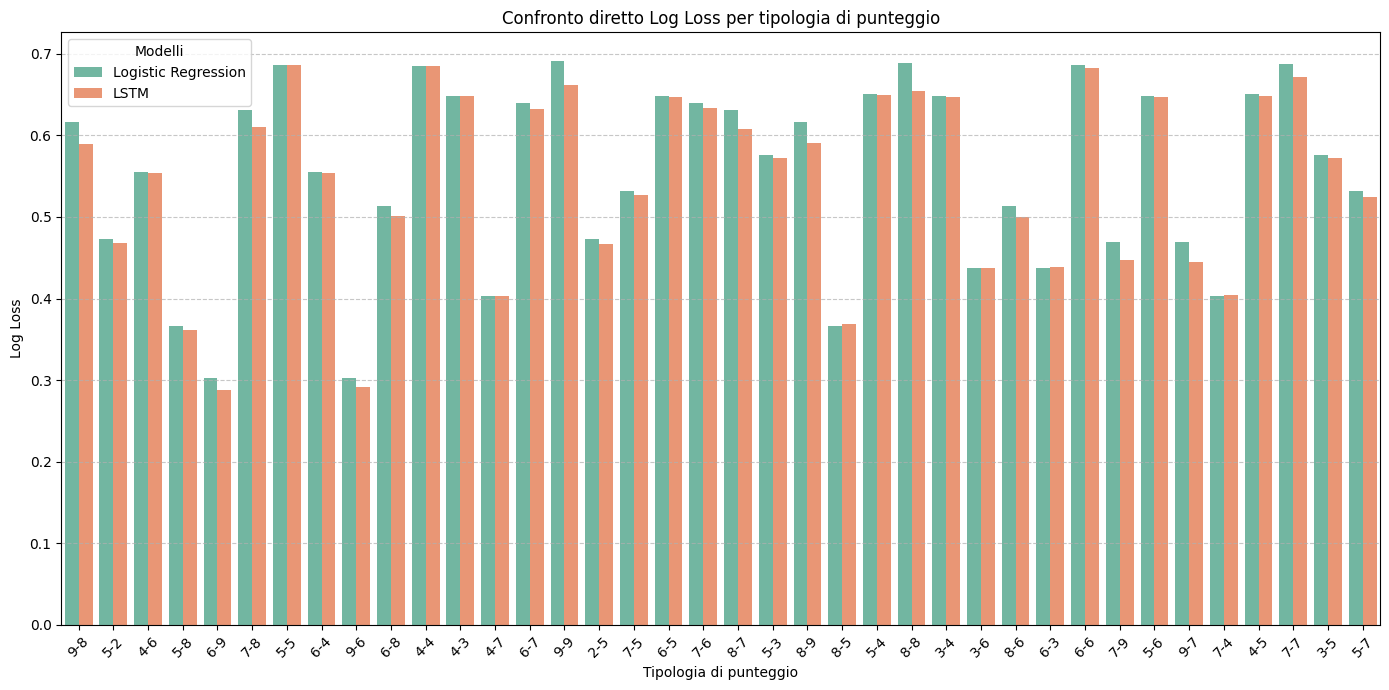

In [ ]:
def grafico_confronto_metriche(risultati):
    """
    Confronta le prestazioni di Logistic Regression e LSTM sui punteggi con un grafico a barre per Log Loss e Brier Score.

    Parametri:
        risultati (list of dict): Lista di risultati con 'file', 'modello', 'log_loss', 'brier_score'.
    """

    df = pd.DataFrame(risultati)
    df['punteggio'] = df['file'].str[:3]

    # Confronto diretto per Log Loss
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=df,
        x='punteggio',
        y='log_loss',
        hue='modello',
        palette='Set2',
        errorbar='sd',
        capsize=0.1
    )
    plt.title("Confronto diretto Log Loss per tipologia di punteggio")
    plt.xlabel("Tipologia di punteggio")
    plt.ylabel("Log Loss")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ['Logistic Regression', 'LSTM']
    plt.legend(handles, labels, title="Modelli", loc='upper left', bbox_to_anchor=(0, 1))
    plt.tight_layout()
    plt.show()
    '''
    # Confronto diretto per Brier Score
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=df,
        x='punteggio',
        y='brier_score',
        hue='modello',
        palette='Set2',
        errorbar='sd',
        capsize=0.1
    )
    plt.title("Confronto diretto Brier Score per tipologia di punteggio")
    plt.xlabel("Tipologia di punteggio")
    plt.ylabel("Brier Score")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ['Logistic Regression', 'LSTM']
    plt.legend(handles, labels, title="Modelli", loc='upper left', bbox_to_anchor=(0, 1))
    plt.tight_layout()
    plt.show()
    '''

grafico_confronto_metriche(risultati_test)

Dal grafico emerge che il modello LSTM mantiene prestazioni superiori in quasi tutte le tipologie di punteggio. Al contrario, la Logistic Regression mostra prestazioni simili a quelle dell'LSTM nelle situazioni di punteggio equilibrato, come 4-4 e 5-5, ma riesce a ottenere risultati migliori in scenari con un distacco maggiore nel punteggio, come 7-4, 6-3 e 8-5.

#### Confusion Matrix

Nel confronto tra i due modelli, abbiamo scelto di non utilizzare metriche standard, poiché la maggior parte dei punteggi risulta facilmente classificabile in una delle due classi. Il nostro obiettivo principale è infatti valutare quale modello fornisca le probabilità migliori.

Per approfondire l'analisi, confronteremo comunque le confusion matrix dei due modelli calcolate su quattro categorie di punteggi: distacchi di 0, 1, 2 e 3 punti. In questo modo, possiamo esaminare se emergono differenze significative nelle prestazioni dei modelli in base a queste specifiche situazioni di punteggio.

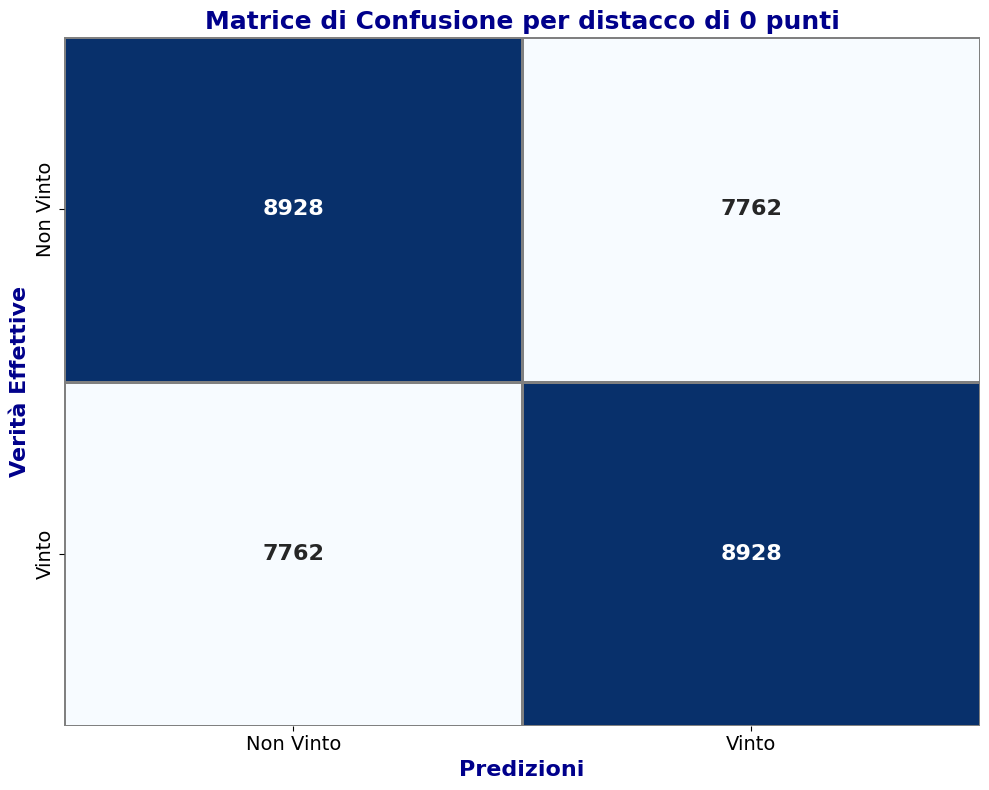

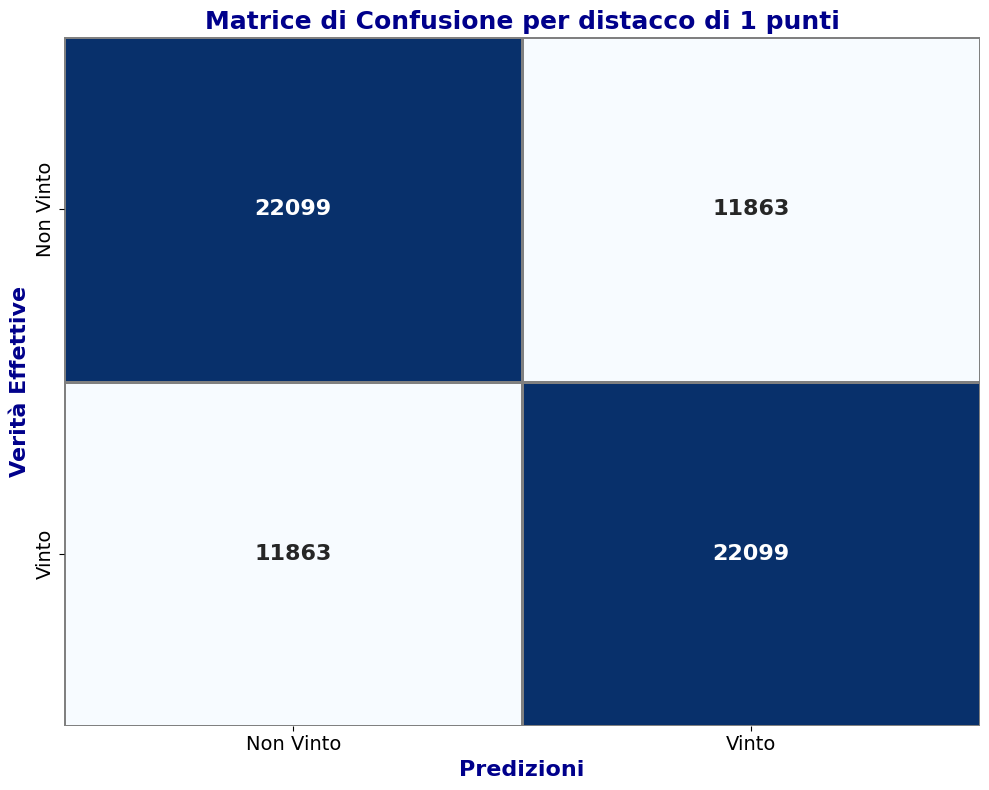

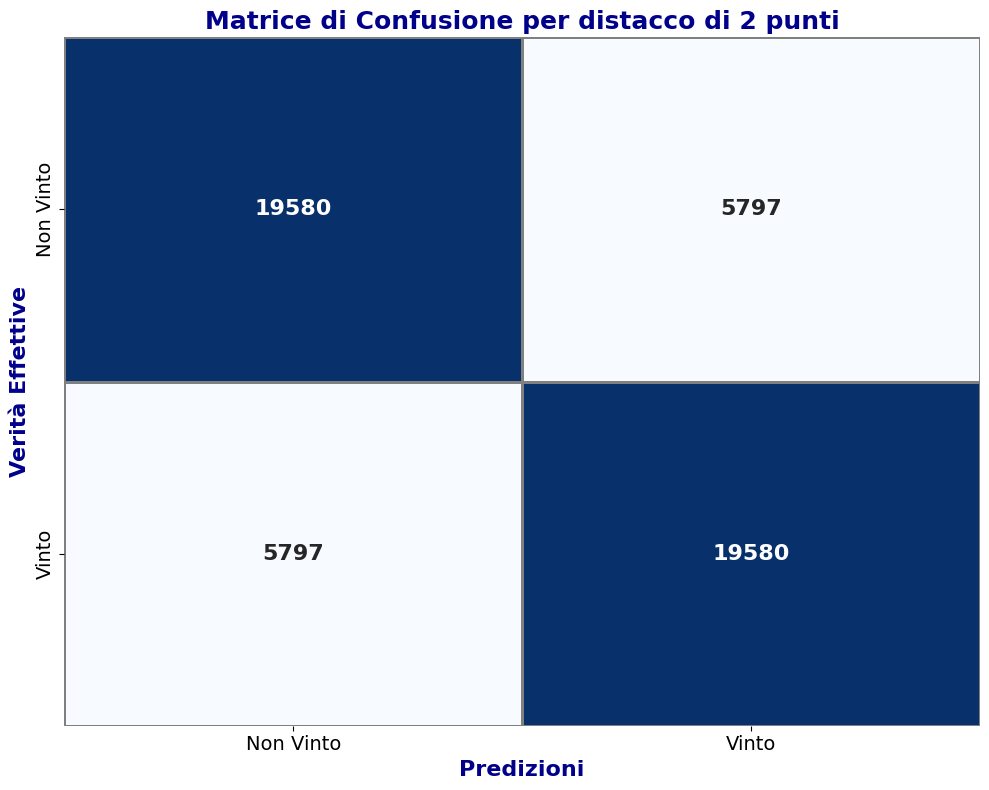

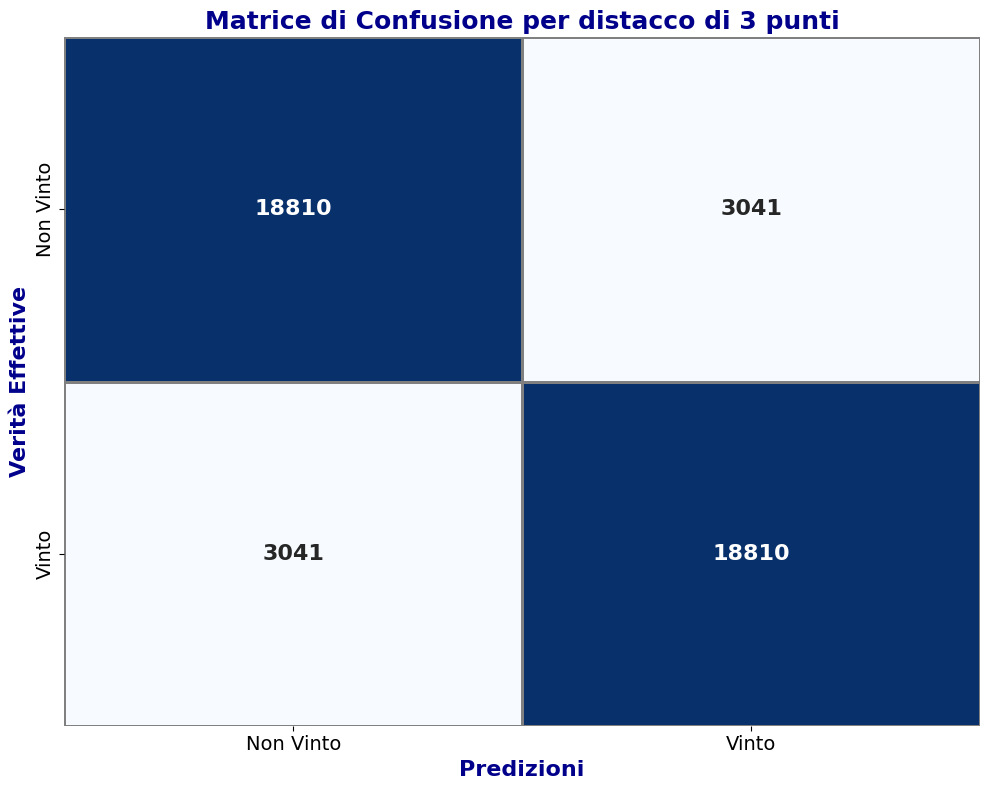

In [ ]:
import re
# Funzione per generare e visualizzare la matrice di confusione per Logistic Regression
def plot_confusion_matrix_logreg(dataset_file, log_reg, scaler_log_reg, cartella_test):
    percorso_file = os.path.join(cartella_test, dataset_file)
    dataset_test = pd.read_csv(percorso_file)


    columns = ['final_set_a', 'final_set_b', 'score_a', 'score_b', 'comeback', 'half_diff', 'third_diff', 'length']
    X_test = dataset_test[columns].values
    Y_test = dataset_test['set_result'].values

    if scaler_log_reg is not None:
        X_test = scaler_log_reg.transform(X_test)

    y_pred_logreg = log_reg.predict_proba(X_test)[:, 1]
    Y_pred_binary = (y_pred_logreg > 0.5).astype(int)

    cm_logreg = confusion_matrix(Y_test, Y_pred_binary)
    cm_percentage_logreg = cm_logreg.astype('float') / cm_logreg.sum(axis=1)[:, np.newaxis] * 100

    # Creazione della figura
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'],
                linewidths=1, linecolor='gray', annot_kws={'size': 16, 'weight': 'bold'},
                cbar_kws={"shrink": 0.8})
    distacco = int(re.search(r'(\d+)', dataset_file).group(1)) if re.search(r'(\d+)', dataset_file) else None
    plt.title(f'Matrice di Confusione per distacco di {distacco} punti',fontsize=18, weight='bold', color='darkblue')
    plt.xlabel('Predizioni', fontsize=16, weight='bold', color='darkblue')
    plt.ylabel('Verità Effettive', fontsize=16, weight='bold', color='darkblue')
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# Cartella di lavoro
cartella_test = "dataset_test_diff"

# Lista dei file CSV da processare
file_list = [
    "dataset_test_diff_0.csv",
    "dataset_test_diff_1.csv",
    "dataset_test_diff_2.csv",
    "dataset_test_diff_3.csv"
]

# Ciclo sui file per generare i grafici
for file in file_list:
    plot_confusion_matrix_logreg(file, log_reg, scaler_log_reg, cartella_test)

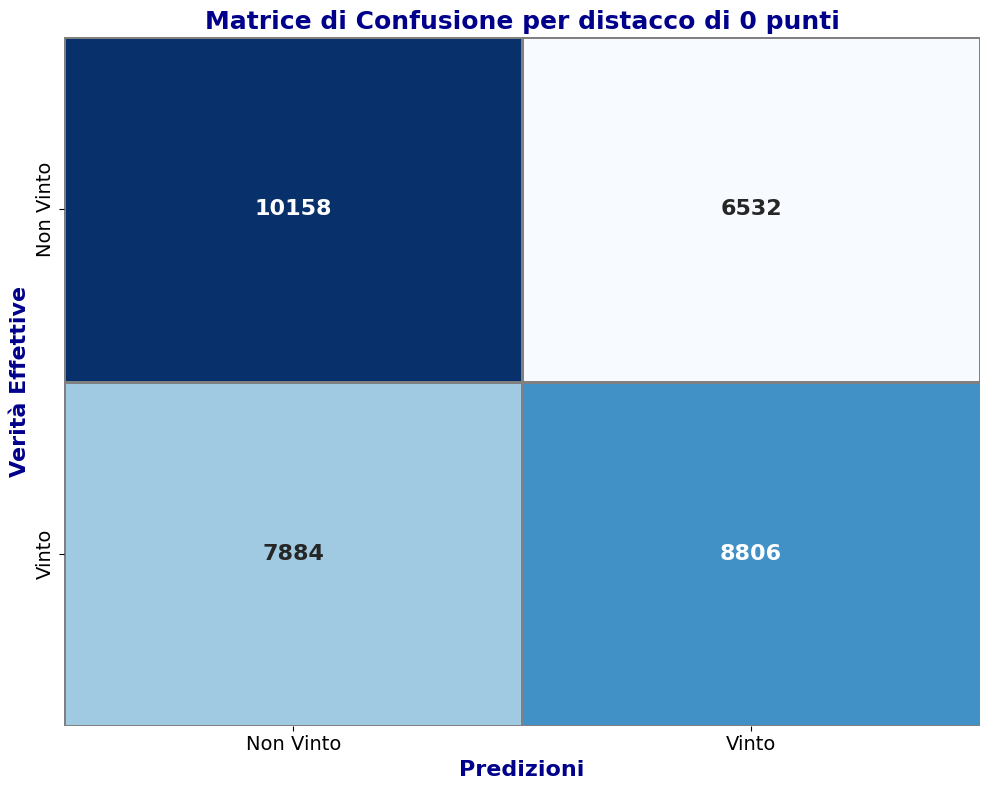

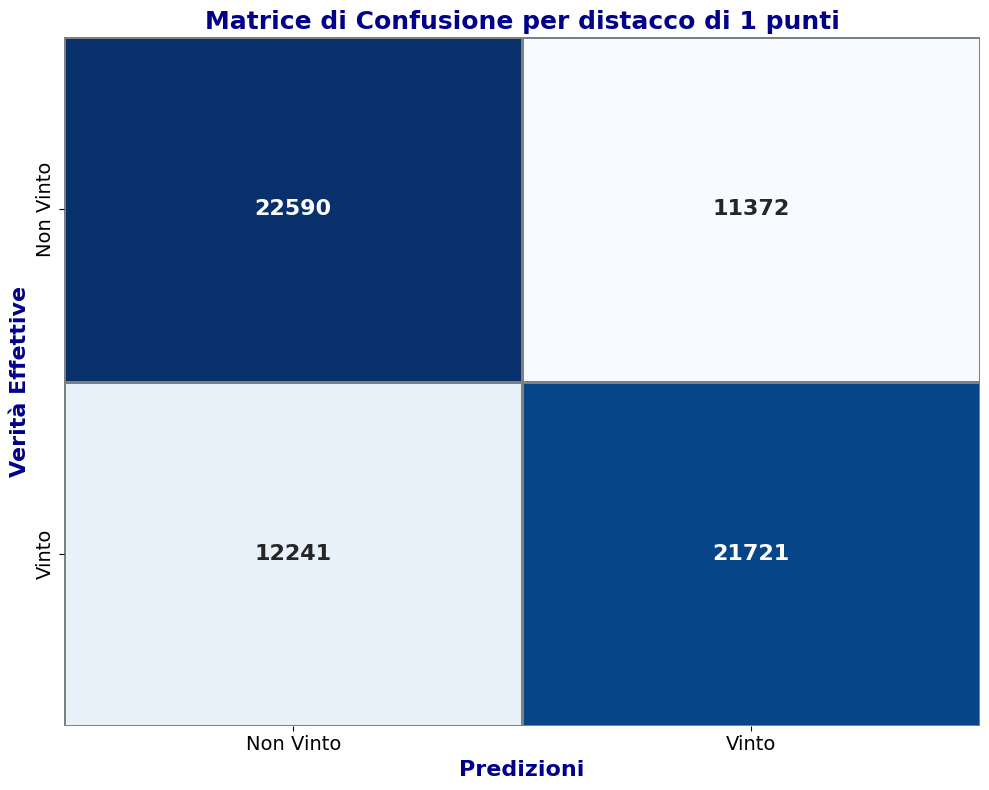

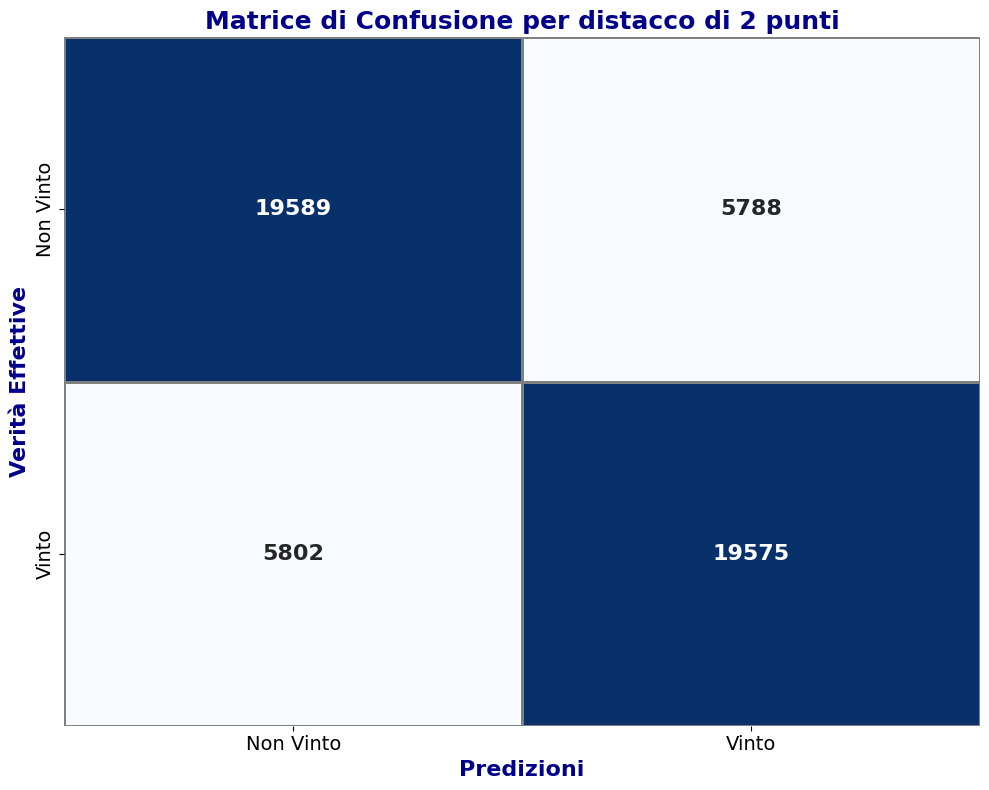

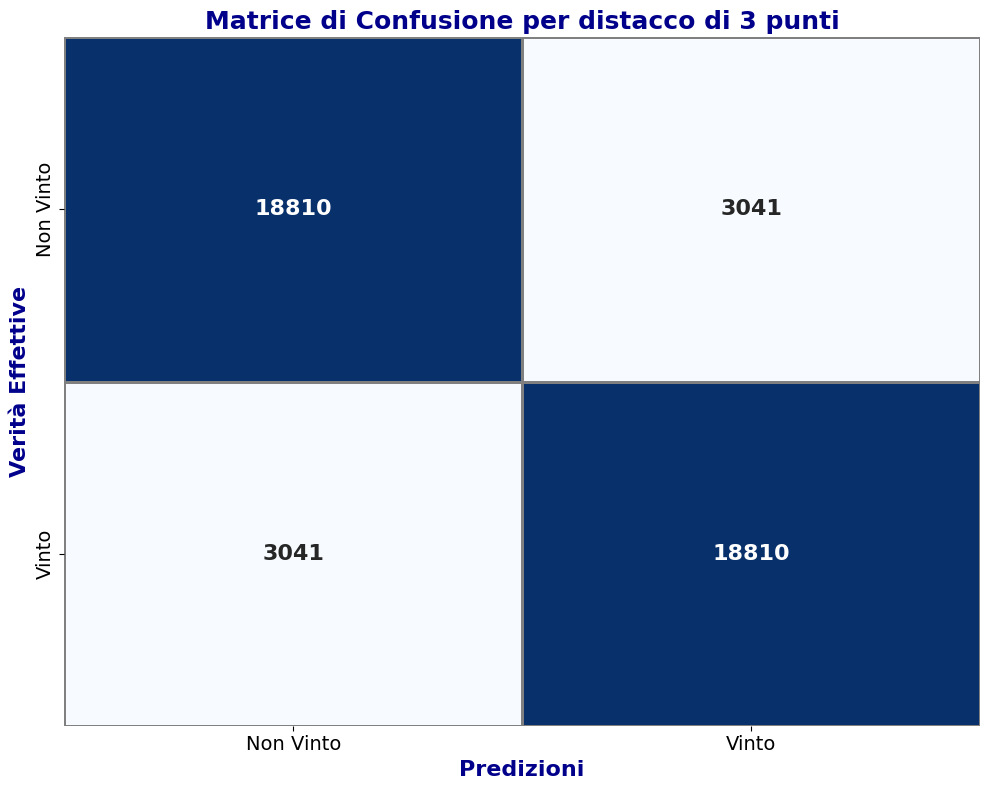

In [ ]:
# Funzione per generare e visualizzare la matrice di confusione per LSTM
def plot_confusion_matrix(dataset_file, lstm_model, cartella_test):
    percorso_file = os.path.join(cartella_test, dataset_file)
    dataset_test = pd.read_csv(percorso_file)

    Y_test = dataset_test['set_result'].values
    player_points_test = dataset_test['points_progression'].values
    global_features_test = dataset_test[['final_set_a', 'final_set_b']].values
    player_points_converted_test = [
        eval(seq) if isinstance(seq, str) else seq for seq in player_points_test
    ]
    X_test_seq = pad_sequences(
        player_points_converted_test,
        maxlen=18,
        padding='post',
        truncating='post',
        value=-1
    )
    X_test_global = global_features_test
    y_pred = lstm_model.predict([X_test_seq, X_test_global], verbose=0).flatten()
    Y_pred_binary = (y_pred > 0.5).astype(int)



    cm = confusion_matrix(Y_test, Y_pred_binary)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'],
                linewidths=1, linecolor='gray', annot_kws={'size': 16, 'weight': 'bold'},
                cbar_kws={"shrink": 0.8})
    distacco = int(re.search(r'(\d+)', dataset_file).group(1)) if re.search(r'(\d+)', dataset_file) else None
    plt.title(f'Matrice di Confusione per distacco di {distacco} punti',fontsize=18, weight='bold', color='darkblue')
    plt.xlabel('Predizioni', fontsize=16, weight='bold', color='darkblue')
    plt.ylabel('Verità Effettive', fontsize=16, weight='bold', color='darkblue')
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


# Cartella di lavoro
cartella_test = "dataset_test_diff"

# Lista dei file CSV da processare
file_list = [
    "dataset_test_diff_0.csv",
    "dataset_test_diff_1.csv",
    "dataset_test_diff_2.csv",
    "dataset_test_diff_3.csv"
]

# Ciclo sui file per generare i grafici
for file in file_list:
    plot_confusion_matrix(file, lstm_model, cartella_test)

Possiamo osservare che, oltre nei casi con distacchi di punti più elevati, dove la scelta della classe è particolarmente facilitata, il modello LSTM, rispetto al modello di Logistic Regression, tende a classificare meglio la classe perdente rispetto a quella vincente.

#### Confronto delle Predizioni
Per un esempio di punteggio (**6-5**), calcoliamo tutte le possibili istanze relative a questa situazione e confrontiamo le differenze nelle predizioni tra le 5 previsioni più alte e quelle più basse per ciascun modello.

In [ ]:
def transform_sequences(seq):
    new_seq = [0, 0]  # Aggiungo 'final_set_a' e 'final_set_b' di esempio
    punti_a = punti_b = rimonta_a = rimonta_b = 0

    for point in seq:
        if point == 1:
            rimonta_a += 1
            rimonta_b = 0
            punti_a += 1
        elif point == 0:
            rimonta_b += 1
            rimonta_a = 0
            punti_b += 1

    # Aggiungo 'score_a', 'score_b', e 'comeback'
    new_seq.extend([punti_a, punti_b, rimonta_a / punti_a if rimonta_a > rimonta_b else -rimonta_b / punti_b])

    # Aggiungo 'half_diff' (differenza nella seconda metà della sequenza)
    half_points = seq[len(seq) // 2:]
    new_seq.append(half_points.count(1) - half_points.count(0))

    # Aggiungo 'third_diff' (differenza nell'ultimo terzo della sequenza)
    third_points = seq[2 * (len(seq) // 3) + 1:]
    new_seq.append(third_points.count(1) - third_points.count(0))

    # Aggiungo 'length'
    new_seq.append(len(seq))

    return new_seq




def genera_vettori(log_reg, lstm_model, features, n_top=5):

    base = [1] * 6 + [0] * 5

    # Otteniamo tutte le permutazioni uniche del vettore base
    permutazioni = set(itertools.permutations(base))


    log_reg_predictions = []
    lstm_predictions = []

    print(len(permutazioni))

    # Iteriamo su tutte le permutazioni uniche
    for vettore in permutazioni:

        sequenza = list(vettore)


        ##### Logistic Regression ######
        X_log_reg = np.array(transform_sequences(sequenza))
        X_log_reg = X_log_reg.reshape(1, -1)
        X_log_reg = scaler_log_reg.transform(X_log_reg)

        y_pred_log_reg = log_reg.predict_proba(X_log_reg)[:, 1]


        ##### LSTM ######
        X_lstm = np.array([sequenza])
        X_lstm = pad_sequences(X_lstm, maxlen=18, padding='post', truncating='post', value=-1)

        y_pred_prob = lstm_model.predict([X_lstm, features], verbose=0)


        # Memorizziamo le predizioni e probabilità
        log_reg_predictions.append((sequenza, y_pred_log_reg))
        lstm_predictions.append((sequenza, y_pred_prob[0]))



    # Ordinamento delle predizioni per probabilità decrescente (top N)
    lstm_predictions_sorted = sorted(lstm_predictions, key=lambda x: x[1], reverse=True)[:n_top]
    log_reg_predictions_sorted = sorted(log_reg_predictions, key=lambda x: x[1], reverse=True)[:n_top]

    # Ordinamento delle predizioni per probabilità crescente (bottom N)
    lstm_predictions_sorted_bottom = sorted(lstm_predictions, key=lambda x: x[1])[:n_top]
    log_reg_predictions_sorted_bottom = sorted(log_reg_predictions, key=lambda x: x[1])[:n_top]



    print(f"\nTop {n_top} predizioni per Log Reg (Probabilità più alta):")
    for i, (sequenza, prob) in enumerate(log_reg_predictions_sorted):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

    print(f"Top {n_top} predizioni per LSTM (Probabilità più alta):")
    for i, (sequenza, prob) in enumerate(lstm_predictions_sorted):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

    print(f"\nBottom {n_top} predizioni per Log Reg (Probabilità più bassa):")
    for i, (sequenza, prob) in enumerate(log_reg_predictions_sorted_bottom):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

    print(f"\nBottom {n_top} predizioni per LSTM (Probabilità più bassa):")
    for i, (sequenza, prob) in enumerate(lstm_predictions_sorted_bottom):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")



features = np.array([[0, 0]])


genera_vettori(log_reg, lstm_model, features)

462

Top 5 predizioni per Log Reg (Probabilità più alta):
1: Sequenza: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], Probabilità: [0.66456541]
2: Sequenza: [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0], Probabilità: [0.66174497]
3: Sequenza: [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], Probabilità: [0.66083418]
4: Sequenza: [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0], Probabilità: [0.66083418]
5: Sequenza: [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0], Probabilità: [0.66083418]
Top 5 predizioni per LSTM (Probabilità più alta):
1: Sequenza: [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1], Probabilità: [0.76961863]
2: Sequenza: [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1], Probabilità: [0.75922066]
3: Sequenza: [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0], Probabilità: [0.7231365]
4: Sequenza: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1], Probabilità: [0.7220869]
5: Sequenza: [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1], Probabilità: [0.71986943]

Bottom 5 predizioni per Log Reg (Probabilità più bassa):
1: Sequenza: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], Probabilità: [0.62937373]
2: Sequenza: [0, 1, 0,

Da questa analisi emerge che, mentre la Logistic Regression tende a privilegiare fortemente le istanze con rimonte avversarie e penalizza in modo significativo quelle con rimonte proprie, il modello LSTM identifica specifiche situazioni di punteggio favorevoli e sfavorevoli. In particolare, nelle situazioni favorevoli, i punti dell'avversario vengono inizialmente accumulati, mentre nelle situazioni sfavorevoli è il nostro giocatore a guadagnare i punti per primo. Questa osservazione suggerisce che l'LSTM ha una capacità superiore di comprendere le dinamiche temporali e le relazioni di sequenza, permettendo una migliore interpretazione dei dati rispetto alla Logistic Regression, che non è in grado di cogliere queste dipendenze temporali.
Inoltre applicando la formula matematica possiamo notare che il modello LSTM tende ad avere predizioni più lontane dalla probabilità matematica rispetto al logistic regression

## **Funzioni Matematiche di testing**
Queste funzioni matematiche sono state sviluppate e utilizzate per validare le prestazioni dei modelli durante il processo di sviluppo, consentendo una valutazione accurata e sistematica dei loro risultati.

In [ ]:
#Funzione che calcola matematicamente la probabilità di vittoria del set

from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * math.comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 0    # Punti già vinti dal giocatore
y = 0    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.5


In [ ]:
#Probabilità di arrivare 10-10

def prob(p, x, y):

    total = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)

    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 6    # Punti già vinti dal giocatore
y = 6    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.2734375


In [ ]:
# Stampiamo la lista delle probabilità matematiche dei punteggi presi in considerazione dai modelli

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Probabilità di vincere un punto
p = 0.5

# Lista per raccogliere i risultati
results = []

# Calcoliamo la probabilità per tutte le combinazioni che ci interessano
for x in range(0, 11):
    for y in range(0, 11):
        if x + y >= 7:
            result = prob(p, x, y)
            if 0.1 < result < 0.9:
                results.append((x, y, result))

results.sort(key=lambda x: x[2])

# Stampare i risultati ordinati
for x, y, result in results:
    print(f"Probabilità per x={x}, y={y}: {result}")


Probabilità per x=6, y=9: 0.109375
Probabilità per x=3, y=7: 0.11328125
Probabilità per x=8, y=10: 0.125
Probabilità per x=2, y=6: 0.1334228515625
Probabilità per x=5, y=8: 0.14453125
Probabilità per x=4, y=7: 0.171875
Probabilità per x=7, y=9: 0.1875
Probabilità per x=3, y=6: 0.19384765625
Probabilità per x=2, y=5: 0.21197509765625
Probabilità per x=6, y=8: 0.2265625
Probabilità per x=9, y=10: 0.25
Probabilità per x=5, y=7: 0.25390625
Probabilità per x=4, y=6: 0.2744140625
Probabilità per x=3, y=5: 0.29052734375
Probabilità per x=8, y=9: 0.3125
Probabilità per x=7, y=8: 0.34375
Probabilità per x=6, y=7: 0.36328125
Probabilità per x=5, y=6: 0.376953125
Probabilità per x=4, y=5: 0.38720703125
Probabilità per x=3, y=4: 0.395263671875
Probabilità per x=4, y=4: 0.5
Probabilità per x=5, y=5: 0.5
Probabilità per x=6, y=6: 0.5
Probabilità per x=7, y=7: 0.5
Probabilità per x=8, y=8: 0.5
Probabilità per x=9, y=9: 0.5
Probabilità per x=10, y=10: 0.5
Probabilità per x=4, y=3: 0.604736328125
Proba